Epoch 1/100
23/23 [==============================] - 12s 173ms/step - loss: 0.5681 - val_loss: 0.6221
Epoch 2/100
23/23 [==============================] - 2s 92ms/step - loss: 0.1855 - val_loss: 0.5618
Epoch 3/100
23/23 [==============================] - 2s 93ms/step - loss: 0.1629 - val_loss: 0.5421
Epoch 4/100
23/23 [==============================] - 2s 89ms/step - loss: 0.1638 - val_loss: 0.4570
Epoch 5/100
23/23 [==============================] - 2s 100ms/step - loss: 0.1593 - val_loss: 0.4497
Epoch 6/100
23/23 [==============================] - 3s 138ms/step - loss: 0.1728 - val_loss: 0.4361
Epoch 7/100
23/23 [==============================] - 4s 182ms/step - loss: 0.1959 - val_loss: 0.4943
Epoch 8/100
23/23 [==============================] - 5s 203ms/step - loss: 0.1726 - val_loss: 0.4569
Epoch 9/100
23/23 [==============================] - 6s 271ms/step - loss: 0.1545 - val_loss: 0.4125
Epoch 10/100
23/23 [==============================] - 7s 289ms/step - loss: 0.1484 - val_loss

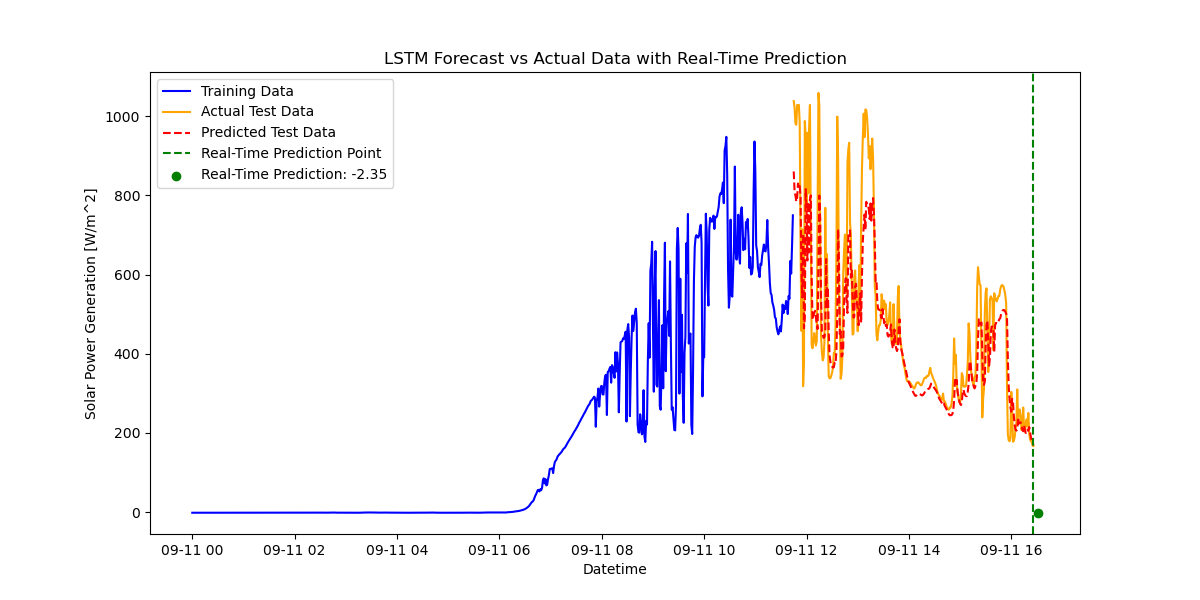

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
data = pd.read_csv('texas_110924.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Convert DATE to datetime format and CST to time format
df['DATE'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format='%m/%d/%Y')
df['CST'] = pd.to_datetime(df['CST'], format='%H:%M').dt.time

# Combine DATE and CST into a single datetime column
df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['DATE'], row['CST']), axis=1)
df.set_index('Datetime', inplace=True)

# Select the column we want and drop missing values
df = df[['Global Horizontal [W/m^2]']].dropna()

# Convert DataFrame to NumPy array for scaling
values = df.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 5))
scaled_data = scaler.fit_transform(values)

# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set the time step
time_step = 30
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Calculate new train/test split
train_size = int(len(X) * 0.5)  # Use 50% for training
# test_size = int(len(X) * 0.25)   # Use 25% for testing (to get up to 75% of the dataset)
# test_size = int(len(X) * 0.1)   # Use 10% for testing (to get up to 60% of the dataset)
# test_size = int(len(X) * 0.05)   # Use 5% for testing (to get up to 55% of the dataset)
# test_size = int(len(X) * 0.15)   # Use 15% for testing (to get up to 65% of the dataset)
test_size = int(len(X) * 0.20)   # Use 20% for testing (to get up to 70% of the dataset)
# Ensure we don't exceed the available indices
train_size = min(train_size, len(X) - time_step)
test_size = min(test_size, len(X) - train_size)

X_train, X_test = X[:train_size], X[train_size:train_size + test_size]
y_train, y_test = y[:train_size], y[train_size:train_size + test_size]

# Build and train LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Save the trained model
model.save('trained_model.h5')
# Predict the test set results
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Function to handle real-time predictions with new data
def predict_real_time(new_data):
    # Convert new_data to a NumPy array if it's not already
    new_data_array = np.array(new_data).reshape(-1, 1)
    
    # Scale the new data using the same scaler fitted on the original data
    scaled_new_data = scaler.transform(new_data_array)

    # Use the last 'time_step' of the scaled data as input for the model
    input_data = scaled_new_data[-time_step:].reshape(1, time_step, 1)

    # Make prediction for the next step
    prediction = model.predict(input_data)

    # Inverse scale the predicted value back to original scale
    prediction = scaler.inverse_transform(prediction)
    
    return prediction[0][0]

# Simulate real-time data
new_data = df['Global Horizontal [W/m^2]'].tail(time_step).values
next_prediction = predict_real_time(new_data)

# Plot the historical data, predicted test data, and real-time forecast
plt.figure(figsize=(12, 6))

# Plot historical actual data (including training and test data)
plt.plot(df.index[:train_size], df['Global Horizontal [W/m^2]'][:train_size], color='blue', label='Training Data')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_rescaled, color='orange', label='Actual Test Data')

# Plot predicted test data
plt.plot(df.index[train_size:train_size + len(predictions_rescaled)], predictions_rescaled, color='red', linestyle='--', label='Predicted Test Data')

# Plot real-time prediction (append to the last index)
plt.axvline(x=df.index[train_size + len(y_test) - 1], color='green', linestyle='--', label='Real-Time Prediction Point')
plt.scatter(df.index[train_size + len(y_test) - 1] + pd.Timedelta(minutes=5), next_prediction, color='green', label=f'Real-Time Prediction: {next_prediction:.2f}', zorder=5)

plt.title('LSTM Forecast vs Actual Data with Real-Time Prediction')
plt.xlabel('Datetime')
plt.ylabel('Solar Power Generation [W/m^2]')
plt.legend()
plt.show()
